In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.layers import Dense, LeakyReLU, Dropout, Input, BatchNormalization
from keras.layers import Reshape, Conv2D, Conv2DTranspose, Flatten, Activation
from keras.models import Model,Sequential

In [4]:
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Normalization
X_train = X_train.astype(np.float32) / 127.5 - 1
print(X_train.shape)
# Reshape
X_train = X_train.reshape(-1, 28, 28, 1)
print(X_train.shape)

(60000, 28, 28)
(60000, 28, 28, 1)


In [5]:
from keras.optimizers import Adam

adam = Adam(lr = 0.0002, beta_1 = 0.5)

# generator model

In [12]:
NOISE_DIM = 10

generator = Sequential(name = 'generator')

generator.add(Dense(256 * 7 * 7, input_shape=(NOISE_DIM,)))
generator.add(LeakyReLU())

generator.add(Reshape((7,7,256))) # output shape

generator.add(Conv2DTranspose(128, kernel_size=3, strides=2,  padding='same'))
#generator.add(BatchNormalization())
generator.add(LeakyReLU())

generator.add(Conv2DTranspose(64, kernel_size=3, strides=2, padding='same'))
generator.add(BatchNormalization())
generator.add(LeakyReLU())

generator.add(Conv2D(1, # layer의 개수(두께) = 1
                     kernel_size=3, padding='same', activation='tanh'))

generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 12544)             137984    
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 12544)             0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 14, 14, 128)       295040    
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 28, 28, 64)        73792     
_________________________________________________________________
batch_normalization_3 (Batch (None, 28, 28, 64)        25

# discriminor model

In [13]:
from keras.initializers import RandomNormal

discriminator = Sequential(name = 'discriminor')

discriminator.add(Conv2D(32, kernel_size=3, strides=2, padding='same', input_shape=(28,28,1)))
discriminator.add(LeakyReLU())

discriminator.add(Dropout(0.5))
discriminator.add(Conv2D(64, kernel_size=3, strides=2, padding='same'))
discriminator.add(LeakyReLU())

discriminator.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
discriminator.add(LeakyReLU())

discriminator.add(Dropout(0.5))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation = 'sigmoid'))

discriminator.summary()

Model: "discriminor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 4, 4, 128)         73856     
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 4, 4, 128)         

In [14]:
discriminator.compile(loss='binary_crossentropy', optimizer=adam)

# GAN model

In [15]:
discriminator.trainable = False

gan_input = Input(shape = (NOISE_DIM,))
x = generator(gan_input)
output = discriminator(x)

gan = Model(gan_input, output, name='gan')
gan.summary()

Model: "gan"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
generator (Sequential)       (None, 28, 28, 1)         507649    
_________________________________________________________________
discriminor (Sequential)     (None, 1)                 94721     
Total params: 602,370
Trainable params: 507,521
Non-trainable params: 94,849
_________________________________________________________________


In [17]:
gan.compile(loss='binary_crossentropy', optimizer=adam)

# batch funtion = 128개씩 468번

In [23]:
def get_batches(data, batch_size):
  batches =[]

  for i in range(data.shape[0] // batch_size):
    batch = data[i * batch_size : (i + 1) * batch_size]
    batches.append(batch)
  return np.asarray(batches) # array의 vector형태로 바꿔줌

# visualize_training function

In [22]:
def visualize_training(epoch, d_losses, g_losses):
  print('epoch :', epoch)
  noise = np.random.normal(0, 1, size=(24, NOISE_DIM))
  generated_images = generator.predict(noise)
  generated_images = generated_images.reshape(-1, 28, 28)

  plt.figure(figsize=(8,4))
  for i in range(generated_images.shape[0]):
    plt.subplot(4, 6, i+1)
    plt.imshow(generated_images[i], interpolation='nearest', cmap='Greys_r')
    plt.axis('off')
  plt.tight_layout()
  plt.show()

In [21]:
  noise = np.random.normal(0, 1, size=(24, NOISE_DIM))
  generated_images = generator.predict(noise)
  print(generated_images.shape)
  generated_images = generated_images.reshape(-1, 28, 28)
  print(generated_images.shape)

(24, 28, 28, 1)
(24, 28, 28)


# Model Training

(128, 28, 28, 1) (256, 28, 28, 1)
epoch : 1


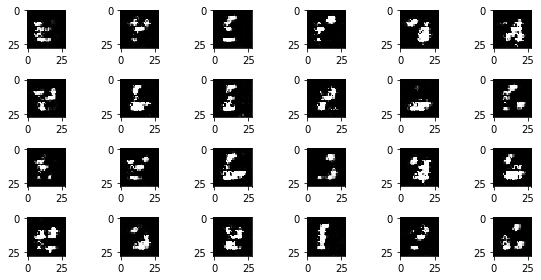

(128, 28, 28, 1) (256, 28, 28, 1)
(128, 28, 28, 1) (256, 28, 28, 1)
(128, 28, 28, 1) (256, 28, 28, 1)
(128, 28, 28, 1) (256, 28, 28, 1)
epoch : 5


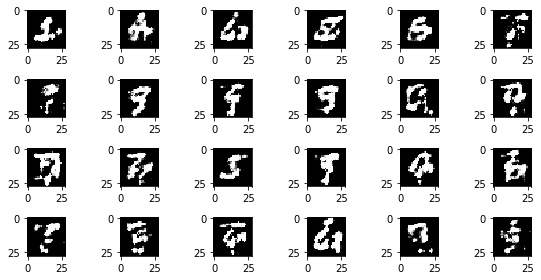

(128, 28, 28, 1) (256, 28, 28, 1)
(128, 28, 28, 1) (256, 28, 28, 1)
(128, 28, 28, 1) (256, 28, 28, 1)
(128, 28, 28, 1) (256, 28, 28, 1)
(128, 28, 28, 1) (256, 28, 28, 1)
epoch : 10


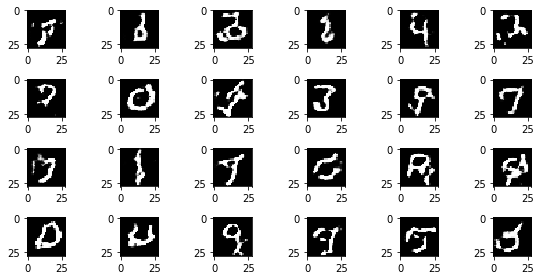

(128, 28, 28, 1) (256, 28, 28, 1)
(128, 28, 28, 1) (256, 28, 28, 1)
(128, 28, 28, 1) (256, 28, 28, 1)
(128, 28, 28, 1) (256, 28, 28, 1)
(128, 28, 28, 1) (256, 28, 28, 1)
epoch : 15


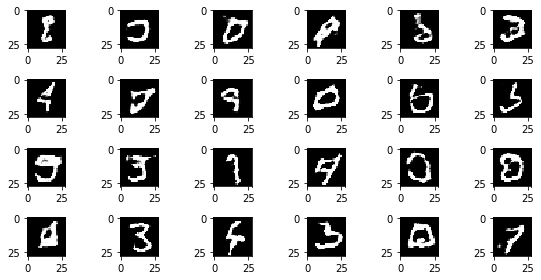

(128, 28, 28, 1) (256, 28, 28, 1)
(128, 28, 28, 1) (256, 28, 28, 1)
(128, 28, 28, 1) (256, 28, 28, 1)
(128, 28, 28, 1) (256, 28, 28, 1)
(128, 28, 28, 1) (256, 28, 28, 1)
epoch : 20


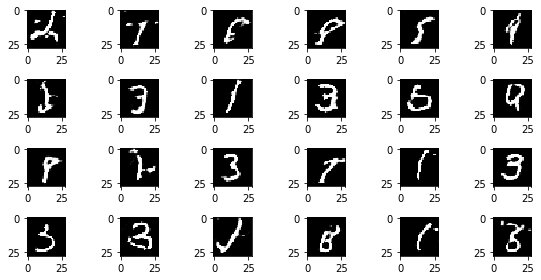

(128, 28, 28, 1) (256, 28, 28, 1)
(128, 28, 28, 1) (256, 28, 28, 1)
(128, 28, 28, 1) (256, 28, 28, 1)
(128, 28, 28, 1) (256, 28, 28, 1)
(128, 28, 28, 1) (256, 28, 28, 1)
epoch : 25


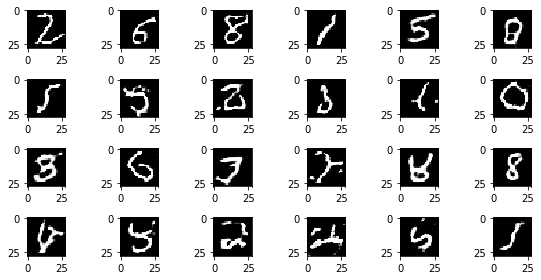

(128, 28, 28, 1) (256, 28, 28, 1)
(128, 28, 28, 1) (256, 28, 28, 1)
(128, 28, 28, 1) (256, 28, 28, 1)
(128, 28, 28, 1) (256, 28, 28, 1)
(128, 28, 28, 1) (256, 28, 28, 1)
epoch : 30


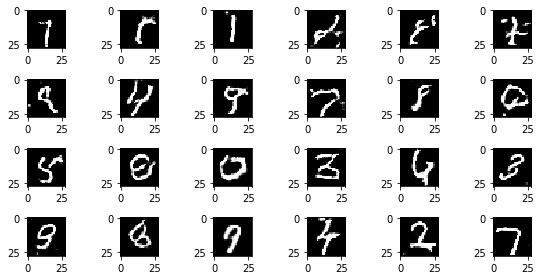

(128, 28, 28, 1) (256, 28, 28, 1)
(128, 28, 28, 1) (256, 28, 28, 1)
(128, 28, 28, 1) (256, 28, 28, 1)
(128, 28, 28, 1) (256, 28, 28, 1)
(128, 28, 28, 1) (256, 28, 28, 1)
epoch : 35


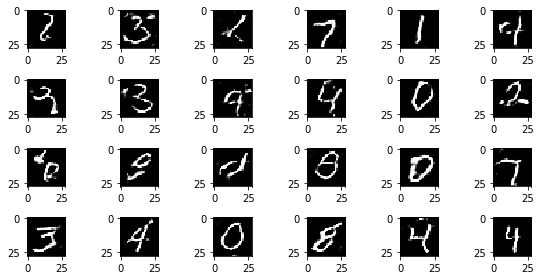

(128, 28, 28, 1) (256, 28, 28, 1)
(128, 28, 28, 1) (256, 28, 28, 1)
(128, 28, 28, 1) (256, 28, 28, 1)
(128, 28, 28, 1) (256, 28, 28, 1)
(128, 28, 28, 1) (256, 28, 28, 1)
epoch : 40


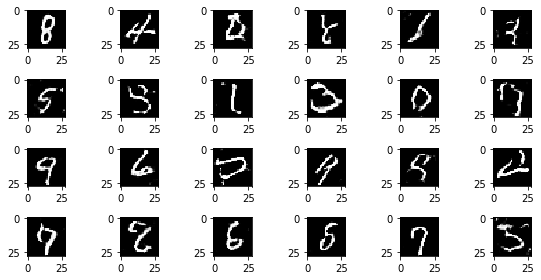

(128, 28, 28, 1) (256, 28, 28, 1)
(128, 28, 28, 1) (256, 28, 28, 1)
(128, 28, 28, 1) (256, 28, 28, 1)
(128, 28, 28, 1) (256, 28, 28, 1)
(128, 28, 28, 1) (256, 28, 28, 1)
epoch : 45


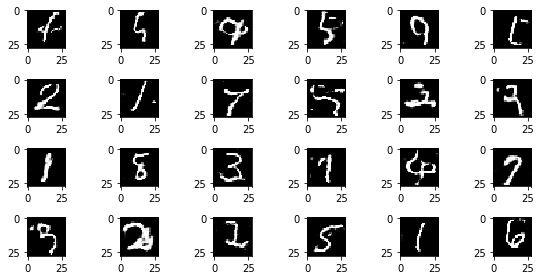

(128, 28, 28, 1) (256, 28, 28, 1)
(128, 28, 28, 1) (256, 28, 28, 1)
(128, 28, 28, 1) (256, 28, 28, 1)
(128, 28, 28, 1) (256, 28, 28, 1)
(128, 28, 28, 1) (256, 28, 28, 1)
epoch : 50


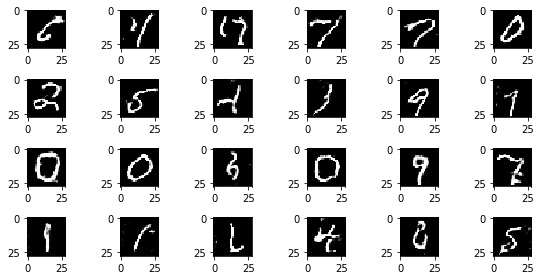

CPU times: user 20min 8s, sys: 1min 12s, total: 21min 20s
Wall time: 24min 26s


In [25]:
%%time

EPOCHS = 50
BATCH_SIZE = 128

d_losses = []
g_losses = []

for epoch in range(1, EPOCHS + 1):
  for real_images in get_batches(X_train, BATCH_SIZE): # X_train = (60000,28,28)
    # Random Noise 생성
    input_noise = np.random.uniform(-1, 1, size=[BATCH_SIZE, NOISE_DIM])

    # FAKE Image 데이터 생성
    generated_images = generator.predict(input_noise)

    # 'gan' 학습용 x 데이터 정의
    x_dis = np.concatenate([real_images, generated_images])

    # 'gan; 학습용 y 데이터 정의
    y_dis = np.zeros( 2*BATCH_SIZE)
    y_dis[:BATCH_SIZE] = 1

    # 'discriminator'학습
    discriminator.trainable = True
    d_loss = discriminator.train_on_batch(x_dis, y_dis)

    # 'gan' 학습
    noise = np.random.uniform(-1, 1, size=[BATCH_SIZE, NOISE_DIM])
    y_gan = np.ones(BATCH_SIZE)

    # discriminator 학습정지
    discriminator.trainable = False
    g_loss = gan.train_on_batch(noise, y_gan)
  
  

  d_losses.append(d_loss)
  g_losses.append(g_loss)

  if epoch == 1 or epoch % 5 == 0:
    visualize_training(epoch, d_losses, g_losses)

#print(generated_images.shape, x_dis.shape)